# IBM Developer Skills Network



# Neural Networks with One Hidden Layer: Noisy XOR

In [1]:
import numpy as np
import torch
import torch.nn as nn # neural network
import torch.nn.functional as F # allow to use activation function
from torch.utils.data import Dataset, DataLoader # create dataset & perform minibatch

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Function to plot the data
def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

In [4]:
# function to calculate accuracy
def accuracy(model, data_set):
    # Rounds prediction to nearest integer 0 or 1
    # Checks if prediction matches the actual values and returns accuracy rate
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

# Neural network Module and Training Function

In [5]:
# Define the class Net with one hidden layer 

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        # D_in is the input size of the first layer (size of input layer)
        # H is the outpout size of the first layer and the input size of the second layer (size of hidden layer)
        # D_out is the output size of the second layer (size of output layer)
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        # Puts x through first layer then sigmoid function
        x = torch.sigmoid(self.linear1(x)) 
        # Puts result of previous line through second layer then sigmoid function
        x = torch.sigmoid(self.linear2(x))
        # Output is a number between 0 and 1 due to the sigmoid function. Whichever the output is closer to, 0 or 1, is the class prediction
        return x

In [8]:
# Define a function to train the model
def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    # Lists to keep track of cost and accuracy
    COST = []
    ACC = []
    # Number of times we train on the entire dataset
    for epoch in range(epochs):
        # Total loss over epoch
        total=0
        # For batch in train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on X value
            yhat = model(x)
            # Measures the loss between prediction and acutal Y value
            loss = criterion(yhat, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
            # Cumulates loss 
            total+=loss.item()
        # Saves cost and accuracy
        ACC.append(accuracy(model, data_set))
        COST.append(total)
        
    # Prints Cost vs Epoch graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    # Prints Accuracy vs Epoch graph
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

    return COST

# Make some data

In [9]:
# Define the class XOR_Data

class XOR_Data(Dataset):
    
    # Constructor
    # N_s is the size of the dataset
    def __init__(self, N_s=100):
        # Create a N_s by 2 array for the X values representing the coordinates
        self.x = torch.zeros((N_s, 2))
        # Create a N_s by 1 array for the class the X value belongs to
        self.y = torch.zeros((N_s, 1))
        # Split the dataset into 4 sections
        for i in range(N_s // 4):
            # Create data centered around (0,0) of class 0
            self.x[i, :] = torch.Tensor([0.0, 0.0]) 
            self.y[i, 0] = torch.Tensor([0.0])

            # Create data centered around (0,1) of class 1
            self.x[i + N_s // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + N_s // 4, 0] = torch.Tensor([1.0])
    
            # Create data centered around (1,0) of class 1
            self.x[i + N_s // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + N_s // 2, 0] = torch.Tensor([1.0])
    
            # Create data centered around (1,1) of class 0
            self.x[i + 3 * N_s // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * N_s // 4, 0] = torch.Tensor([0.0])

            # Add some noise to the X values to make them different
            self.x = self.x + 0.01 * torch.randn((N_s, 2))
        self.len = N_s

    # Getter
    def __getitem__(self, index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_stuff(self):
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")
        plt.legend()

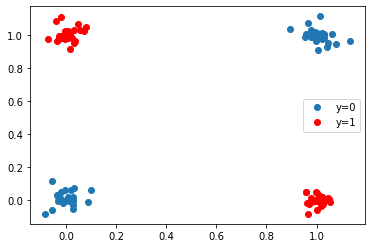

In [10]:
# Create the Dataset
data_set = XOR_Data()
data_set.plot_stuff()

# One Neuron

In [11]:
# Create a neural network with one neuron in the hidden layer.
model = Net(2, 1, 1) # 2 input, 1 hidden, 1 output

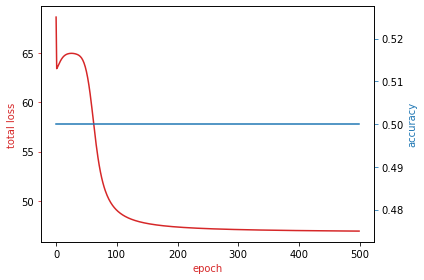

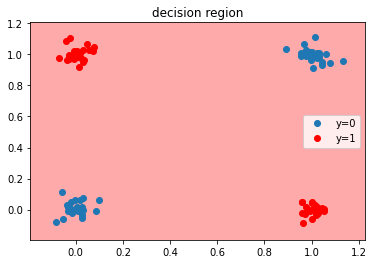

In [12]:
# Train the model
learning_rate = 0.1

# Set criterion
criterion = nn.BCELoss()

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Set train loader
train_loader = DataLoader(dataset=data_set, batch_size=1)

# Train the model
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)

plot_decision_regions_2class(model, data_set)

One Neuron model can not predict the correct value!

# Two Neurons

In [13]:
model = Net(2, 2, 1)

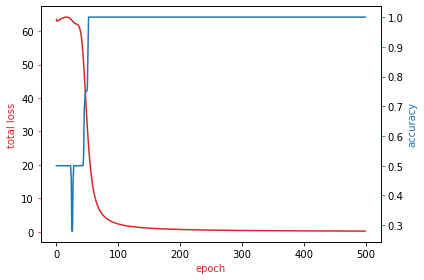

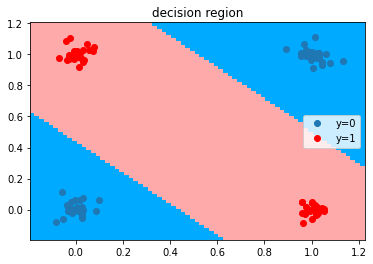

In [14]:
# Train the model
learning_rate = 0.1

# Criterion
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Data Loader
train_loader = DataLoader(dataset=data_set, batch_size=1)

# Train the model
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)

plot_decision_regions_2class(model, data_set)

2 Neurons model perfectly predict the result!

# Three Neurons

In [15]:
model = Net(2, 3, 1)

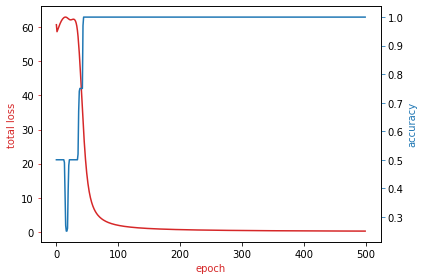

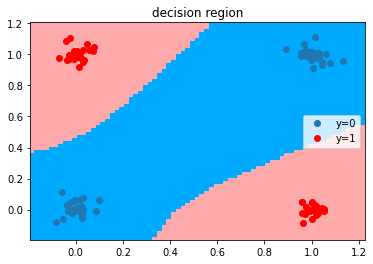

In [16]:
# Train the model
learning_rate = 0.1

# Criterion
criterion=nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# data loader
train_loader = DataLoader(dataset=data_set, batch_size=1)

# train
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)

plot_decision_regions_2class(model, data_set)

100% accuracy with different boundary shape with 2 neurons